# Programming Exercise 2: Logistic Regression with regularization

Regularized Logistic regression is a classification algorithm 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
 

Number of samples 118
Number of parameters:  2
y shape (118,)


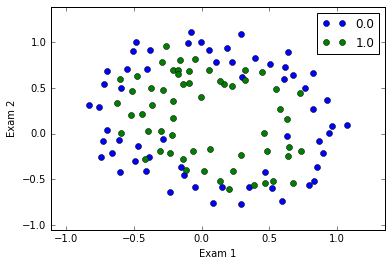

In [2]:
data = np.loadtxt('ex2data2.txt', delimiter=',')

X = data[:,0:2]
y = data[:,2]  # differs from y = data[:, 2:3]
m,n = X.shape
print('Number of samples', m)
print('Number of parameters: ', n)
print('y shape', y.shape)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
groups = df.groupby(y)
plt.margins(0.15)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)

plt.xlabel('Exam 1')
plt.ylabel('Exam 2')
plt.legend()
plt.show()


## try solution directly from scikit learn

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001)

#lr = LogisticRegression() # default solver to 'liblinear"

# lbfgs seems to be Same as mine
lr = LogisticRegression(solver='lbfgs', C=0.4)  # C = 1/lambda (default = 1, if lower, regularization is stronger)
# lr = LogisticRegression(solver='sag', max_iter = 1000000000)  # ???
#lr = LogisticRegression(solver='newton-cg', max_iter = 1000000000)  # seems quite the same as lbfgs

lr.fit(X_train,y_train)
lr.get_params()

print('Coeff = {}, intercept = {}'.format(lr.coef_, lr.intercept_ ))

print('Score on training set : ', lr.score(X_train,y_train))
print('Score on test set : ', lr.score(X_test,y_test))


X_small_test = [
    [0,0],
    [-0.25,0.25],
    [0.2,0.5],
    [1,-1],
    [1,1],
    [-0.25, 1.5],  # expected as human : 1 1 1 0 0 0  
    [0,1],
    [0,-1]]
print('Predict on small test : ', lr.predict(X_small_test))


Coeff = [[-0.2031712  -0.01881999]], intercept = [-0.03616197]
Score on training set :  0.461538461538
Score on test set :  1.0
Predict on small test :  [ 0.  1.  0.  0.  0.  0.  0.  0.]


[-0.03616197 -0.2031712  -0.01881999]


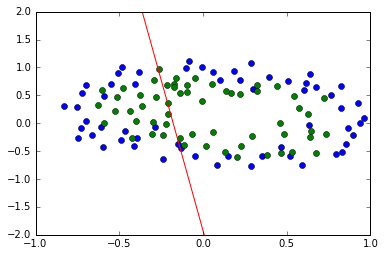

In [28]:
def plotDecisionBoundary(theta, X):
    # draw the line according to theta parameters
    plot_x = [min(X[:,1])-1, max(X[:,1]+1)]
    #print('plot_x:',plot_x)

    plot_y = (-1/theta[2]) * (np.multiply(theta[1],plot_x) + theta[0])
    #print('plot_y:',plot_y)

    plt.plot(plot_x, plot_y)

    plt.show()

test = np.append(lr.intercept_, lr.coef_)
print(test)
plt.xlim(-1,1)
plt.ylim(-2,2)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
    
plotDecisionBoundary(test, X_train)